In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pprint import pprint
import matplotlib.pyplot as plt

In [3]:
import networkx as nx
from collections import defaultdict
import warnings
from tethne import networks
from tethne.utilities import _iterable

# Introduction to Tethne: Time-Variant Networks

Now that we can index our ``Corpus`` temporally using the ``slice`` method, we can start to build time-variant networks. In this workbook we'll build a time-variant coauthor network using a ``GraphCollection``.

## Before you start

* Download the Web of Science practice dataset from [here](http://devo-evo.lab.asu.edu/methods/tethne/datasets.zip), and store it in a place where you can find it. You'll need the full path to your dataset.
* Complete the tutorial **"Time and Change, Working with Corpora"**

## Loading data

We'll use the same WoS dataset that we've used in previous workbooks. Load it up using **``read()``**.

In [4]:
from tethne.readers.wos import read
datadirpath = '/Users/erickpeirson/Projects/tethne-notebooks/data/wos'
MyCorpus = read(datadirpath)

## Slicing our ``Corpus``

To generate a time-variant network, we must first slice our ``Corpus`` temporally. Many research questions about social networks like coauthor networks involve how nodes recruit new neighbors. To look at this in the context of our dataset, we'll want to keep old nodes and edges around even if they don't show up in more recent slices. So we'll do a simple 1-year time-period slice, but with ``cumulative=True``.

**Note**: In early versions of Tethne, ``slice()`` performed indexing on the spot, and stored the results in memory. As of v0.7.x, ``slice()`` returns a generator over slices. ``slice()`` also no longer operates on non-date fields, since this functionality is already provided by ``index()``.

In [5]:
MyCorpus.slice(window_size=10, step_size=2)

<generator object slice at 0x11298cf00>

## Creating a ``GraphCollection``

As the name suggests, a ``GraphCollection`` is a container for graphs. The ``GraphCollection`` class gives us some convenient methods for generating and interrogating time-variant networks. The ``GraphCollection.build`` method allows us to build a series of graphs from our ``Corpus`` -- one graph per slice -- all in one step.

First, import ``GraphCollection`` directly from the ``tethne`` package.

In [6]:
from tethne import GraphCollection

In [7]:
from tethne.networks import coauthors

The following code builds a collection of co-authorship networks, using a 3-year cumulative time-window.

In [64]:
MyGraphCollection = GraphCollection(MyCorpus, coauthors, slice_kwargs={'window_size': 10, 'step_size': 2})

We passed the ``GraphCollection`` constructor three arguments in the code-block above: 

1. Our ``Corpus`` instance;
2. A network-building function (``coauthors``);
3. Keyword arguments for ``slice()``.

We can use the ``plot_node_distribution`` and ``plot_edge_distribution`` methods to see how many nodes and edges are in the graph at each point in time (technically, how many nodes and edges are in each graph, each of which corresponds to a slice in the ``Corpus``).

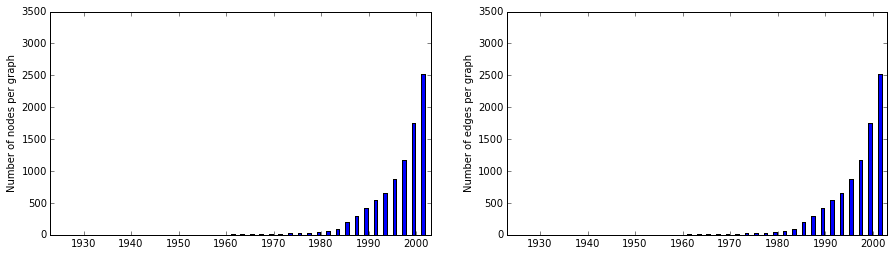

In [65]:
node_distribution = MyGraphCollection.node_distribution()
edge_distribution = MyGraphCollection.edge_distribution()

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.bar(node_distribution.keys(), node_distribution.values())
plt.xlim(min(node_distribution.keys()), max(node_distribution.keys()))
plt.ylabel('Number of nodes per graph')

plt.subplot(122)
plt.bar(edge_distribution.keys(), edge_distribution.values())
plt.xlim(min(edge_distribution.keys()), max(edge_distribution.keys()))
plt.ylabel('Number of edges per graph')
plt.show()

## Analyzing time-variant networks

The ``GraphCollection`` makes it easy to apply algorithms from [NetworkX](http://networkx.github.io/documentation/networkx-1.9/reference/algorithms.html) across the whole time-variant network (i.e. to all graphs in the ``GraphCollection``). 

The method ``analyze`` applies an algorithm to all of the graphs in the ``GraphCollection``.

In [66]:
dc = MyGraphCollection.analyze('degree_centrality')

In [67]:
dc[1987].items()[20:30]

[(57, 0.013333333333333334),
 (58, 0.01),
 (59, 0.0033333333333333335),
 (60, 0.013333333333333334),
 (61, 0.0033333333333333335),
 (62, 0.013333333333333334),
 (63, 0.006666666666666667),
 (64, 0.013333333333333334),
 (65, 0.013333333333333334),
 (66, 0.006666666666666667)]

In [68]:
bcentrality = MyGraphCollection.analyze('betweenness_centrality')

Some algorithms, like "degree_centrality" and "betweenness_centrality" return a value for each node in each graph. In that case, the nodes in each graph are updated with those values.

In [75]:
MyGraphCollection[2003].nodes(data=True)[15:17]   # Shows the attributes for two of the nodes in the 2008 graph.

[(231,
  {'betweenness_centrality': 0.0,
   'count': 1.0,
   'degree_centrality': 0.002589182968929804,
   'documentCount': 1}),
 (251,
  {'betweenness_centrality': 0.0,
   'count': 1.0,
   'degree_centrality': 0.00028768699654775604,
   'documentCount': 1})]

The method ``plot_attr_distribution`` can help to visualize the results of an algorithm across the graphs in the ``GraphCollection``. In the example below, ``attr='degree_centrality'`` selects the degree_centrality attribute, ``etype='node'`` indicates that the attribute belongs to nodes (not edges), and ``stat=mean`` specifies that the Python function ``mean`` should be applied to the collection of values in each graph.

We can use ``node_history`` to look at how the attribute of a particular node changes across graphs. In the example below, the specified node appears first in 2008, and its centrality increases through 2011.

In [76]:
node_id = MyGraphCollection.node_lookup[(u'WARWICK', u'SI')]
warwick_centrality = MyGraphCollection.node_history(node_id, 'degree_centrality')

In [77]:
warwick_centrality.items()[:20]

[(1969, 0.09090909090909091),
 (1971, 0.09090909090909091),
 (1973, 0.047619047619047616),
 (1975, 0.03333333333333333),
 (1977, 0.03571428571428571),
 (1979, 0.02702702702702703)]

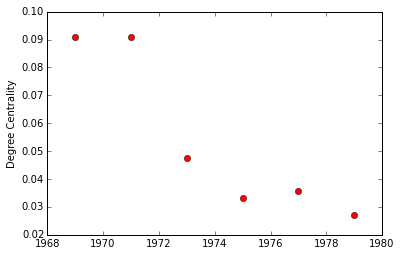

In [78]:
plt.plot(warwick_centrality.keys(), warwick_centrality.values(), 'ro')
plt.ylabel('Degree Centrality')
plt.show()

## Node indexing

Note that in the example above we had to convert our author name, ``(u'WARWICK', u'SI')``, to an id, ``node_id``. That's because the ``GraphCollection`` indexes all of the nodes so that we can track them across graphs. The index is stored in ``GraphCollection.node_index``:

In [79]:
MyGraphCollection.node_index.items()[0:10]    # The first ten nodes in the index.

[(0, (u'ANANTARAM', '')),
 (1, (u'SEN', u'K')),
 (2, (u'LAROI', u'GH')),
 (3, (u'DUGLE', u'JR')),
 (4, (u'BOSCHHUIR', '')),
 (5, (u'GROOT', u'J')),
 (6, (u'LEWIS', u'MC')),
 (7, (u'WILKINS', u'DA')),
 (8, (u'TAMARIN', u'RH')),
 (9, (u'MALECHA', u'SR'))]

In [80]:
MyGraphCollection.node_index[2467]    # Get the name of a specific node.

(u'PORTER', u'WARREN P')

To look up the index of a node based on its name (e.g. an author name), use ``GraphCollection.node_lookup``:

In [81]:
MyGraphCollection.node_lookup.items()[0:10]    # The first ten nodes in the lookup table.

[((u'LIU', u'SR'), 1069),
 ((u'IVEY', u'CHRISTOPHER T'), 2146),
 ((u'BURNS', u'KEVIN C'), 4149),
 ((u'FERRIER', u'SHARON M'), 4143),
 ((u'ROOD', u'SB'), 1454),
 ((u'YOKOYAMA', u'JUN'), 4108),
 ((u'FRESCHET', u'GREGOIRE T'), 3885),
 ((u'SEXTON', u'JASON P'), 3980),
 ((u'PEARSONS', u'TODD N'), 1452),
 ((u'BALTISBERGER', u'MATTHIAS'), 4138)]

In [82]:
MyGraphCollection.node_lookup[(u'SEXTON', u'JASON P')]    # Get the index of a specific node.

3980

## Writing dynamic graphs

Cytoscape provides support for Dynamic XGMML, which is a network file format that supports time-variant graphs. You can write DXGMML using the ``to_dxgmml`` function in the ``writers.collection`` module.

In [83]:
from tethne.writers import collection

In [84]:
outpath = '/Users/erickpeirson/Projects/tethne-notebooks/output/my_dynnetwork.xgmml'
collection.to_dxgmml(MyGraphCollection, outpath)

Here's a snapshot from around 2008. Node size is mapped to betweenness centrality.

![](http://devo-evo.lab.asu.edu/methods/tethne/images/coauthors_dyn.png)

**Caution:** Cytoscape still has a hard time with large dynamic graphs. This is mostly useful for heuristic purposes, or small graphs.